# Analysis of the cleaned Frasier Transcript Dataset

This takes a look at the nature of the data, looking into how distinct the different dialects of each main character are

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./data/cleanedTranscript.csv")
data.head(3)

,character,lines,season,episode,gender,title,directedBy,writtenBy,originalAirDate,viewershipInMillions,imdbVotes,imdbRatings,characterName,actorName,characterType,episodeCount
0,Frasier,listen to yourself bob you follow her to work ...,1,1,male,The Good Son,James Burrows,David Angell & Peter Casey & David Lee,1993-09-16,28.0,528,8.8,Frasier Crane,Kelsey Grammer,main,1.0
1,Roz,yes dr crane on line four we have russell from...,1,1,female,The Good Son,James Burrows,David Angell & Peter Casey & David Lee,1993-09-16,28.0,528,8.8,Roz Doyle,Peri Gilpin,main,1.0
2,Frasier,hello russell this is dr frasier crane im list...,1,1,male,The Good Son,James Burrows,David Angell & Peter Casey & David Lee,1993-09-16,28.0,528,8.8,Frasier Crane,Kelsey Grammer,main,1.0


## Word Frequency Analysis

In [27]:
def getNMostCommonWords(n: int) -> list[str]:
    """This gets the top n most common words from a file containing most common english words"""
    with open("./data/frasierWordCounts.txt") as file:
        commonWords =  file.read()

    # Get just the word from every pair
    commonWords = [pair.split()[0] for pair in commonWords.split("\n")[:-1]]
    return commonWords[:n]

In [28]:
def getWordCounts(data, character: str=None, wordWeights: dict[str, float]=None) -> dict[str, int]:
    """This function gets the word frequencies from the lines in a transcript dataset
    Params:
    data - A Pandas dataframe with transcript data
    character - Optional parameter specifying a character to get word frequencies for
    Returns: A dictionary of words and their frequency"""
    # If a character is specefied, filter the data by that character
    # Otherwise, just keep the data the same
    if character:
        filteredData = data[data["character"] == character]
    else:
        filteredData = data

    # Get the word counts for each line
    wordCounts = defaultdict(int)
    for line in filteredData["lines"]:
        for word in line.split():
            wordCounts[word] += 1

    # If there are words the user wants weighted 
    if wordWeights:
        for word, weight in wordWeights.items():
            wordCounts[word] *= weight
    
    return wordCounts

{'you': 0.05, 'i': 0.05, 'the': 0.05, 'to': 0.05, 'a': 0.05, 'and': 0.05, 'it': 0.05, 'of': 0.05, 'that': 0.05, 'oh': 0.05, 'well': 0.05, 'in': 0.05, 'me': 0.05, 'my': 0.05, 'this': 0.05, 'is': 0.05, 'for': 0.05, 'just': 0.05, 'im': 0.05, 'have': 0.05, 'what': 0.05, 'know': 0.05, 'no': 0.05, 'your': 0.05, 'on': 0.05, 'was': 0.05, 'be': 0.05, 'its': 0.05, 'all': 0.05, 'we': 0.05, 'with': 0.05, 'not': 0.05, 'dont': 0.05, 'so': 0.05, 'but': 0.05, 'right': 0.05, 'do': 0.05, 'are': 0.05, 'yes': 0.05, 'about': 0.05, 'he': 0.05, 'here': 0.05, 'niles': 0.05, 'youre': 0.05, 'like': 0.05, 'out': 0.05, 'get': 0.05, 'at': 0.05, 'her': 0.05, 'if': 0.05, 'frasier': 0.05, 'up': 0.05, 'now': 0.05, 'can': 0.05, 'dad': 0.05, 'were': 0.05, 'go': 0.05, 'one': 0.05, 'thats': 0.05, 'think': 0.05, 'going': 0.05, 'there': 0.05, 'she': 0.05, 'see': 0.05, 'as': 0.05, 'how': 0.05, 'got': 0.05, 'him': 0.05, 'good': 0.05, 'ill': 0.05, 'roz': 0.05, 'time': 0.05, 'really': 0.05, 'did': 0.05, 'when': 0.05, 'little': 

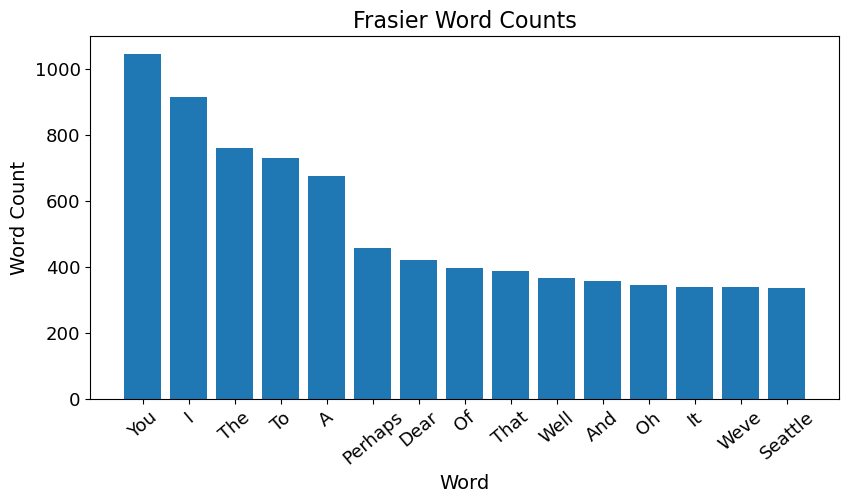

In [47]:
def wordFrequencyChart(data, character: str, numWordsDisplay: int=None, topNWeightedWords=None, wordWeight=.1):
    """This function makes a plot showing the word frequency of a specific character"""
    # Create plot
    fig, ax = plt.subplots(figsize=(10,6))
    fig.tight_layout(pad=7.5)
    fig.set_facecolor('White')

    # Get word weights
    wordWeights = {}
    for word in getNMostCommonWords(topNWeightedWords):
        wordWeights[word] = wordWeight

    print(wordWeights)
    # Get word counts for character
    characterCounts = list(getWordCounts(data, character, wordWeights).items())
    characterCounts.sort(key=lambda wordCount: wordCount[1], reverse=True)
    # If a max number of words is specified then select only those words
    if numWordsDisplay:
        characterCounts = characterCounts[:numWordsDisplay]

    # Get the words and frequencies on their own
    words = [x[0].title() for x in characterCounts]
    frequencies = [x[1] for x in characterCounts]

    # Create bars
    ax.bar(words, frequencies)
    ax.set_xlabel("Word", fontsize=14)
    ax.set_ylabel("Word Count", fontsize=14)
    ax.set_title(f'{character.title()} Word Counts', fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_xticklabels(words, rotation=40)

wordFrequencyChart(data, "Frasier", 15, 250, .05)